In [1]:
# Setup and Imports

# Install the Ultralytics library, which contains the YOLOv8 framework
!pip install -q ultralytics

# Import all required libraries
import os
import shutil
import random
import yaml
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import time
from glob import glob
from ultralytics import YOLO
from IPython.display import Image as IPImage, display
from PIL import Image
from tqdm.notebook import tqdm
import torch

print("Setup Complete")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultraly

In [2]:
# Dataset Download, Conversion, and Structuring

if not os.path.exists('/content/yellow-sticky-traps-dataset'):
    !git clone -q https://github.com/md-121/yellow-sticky-traps-dataset
else:
    print("Dataset repository already cloned")

# Define Paths and Create Clean YOLO-style Directory Structure
SOURCE_IMAGES_DIR = '/content/yellow-sticky-traps-dataset/images'
SOURCE_ANNOTATIONS_DIR = '/content/yellow-sticky-traps-dataset/annotations'
YOLO_DATASET_DIR = '/content/yolo_dataset'
if os.path.exists(YOLO_DATASET_DIR):
    shutil.rmtree(YOLO_DATASET_DIR)
PATHS = {
    'train_images': os.path.join(YOLO_DATASET_DIR, 'images/train'),
    'val_images': os.path.join(YOLO_DATASET_DIR, 'images/val'),
    'train_labels': os.path.join(YOLO_DATASET_DIR, 'labels/train'),
    'val_labels': os.path.join(YOLO_DATASET_DIR, 'labels/val')
}
for path in PATHS.values():
    os.makedirs(path, exist_ok=True)

# Find and Match All Image/Annotation Pairs
all_image_paths = glob(os.path.join(SOURCE_IMAGES_DIR, '*.jpg'))
image_basenames = {os.path.splitext(os.path.basename(p))[0] for p in all_image_paths}
all_annot_paths = glob(os.path.join(SOURCE_ANNOTATIONS_DIR, '*.xml'))
valid_pairs = []
for annot_path in all_annot_paths:
    basename = os.path.splitext(os.path.basename(annot_path))[0]
    if basename in image_basenames:
        image_path = os.path.join(SOURCE_IMAGES_DIR, basename + '.jpg')
        valid_pairs.append({'xml': annot_path, 'img': image_path})

# Shuffle and split the list of VERIFIED pairs
random.seed(42)
random.shuffle(valid_pairs)
split_idx = int(len(valid_pairs) * 0.8)
train_pairs = valid_pairs[:split_idx]
val_pairs = valid_pairs[split_idx:]

# The Conversion Function and Processing Loop
CLASS_MAPPING = {'MR': 0, 'NC': 1, 'WF': 2}
def convert_and_copy(pairs, img_dest, label_dest):
    for pair in tqdm(pairs, desc=f"Processing {os.path.basename(img_dest)} set"):
        img = Image.open(pair['img'])
        width, height = img.size
        shutil.copy(pair['img'], img_dest)

        tree = ET.parse(pair['xml'])
        root = tree.getroot()
        yolo_lines = []
        for obj in root.findall('object'):
            class_id = CLASS_MAPPING[obj.find('name').text]
            bndbox = obj.find('bndbox')
            xmin, ymin, xmax, ymax = [float(bndbox.find(t).text) for t in ['xmin', 'ymin', 'xmax', 'ymax']]
            x_center, y_center = (xmin + xmax) / 2 / width, (ymin + ymax) / 2 / height
            width_norm, height_norm = (xmax - xmin) / width, (ymax - ymin) / height
            yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}")

        base_name = os.path.splitext(os.path.basename(pair['img']))[0]
        with open(os.path.join(label_dest, base_name + '.txt'), 'w') as f:
            f.write("\n".join(yolo_lines))

convert_and_copy(train_pairs, PATHS['train_images'], PATHS['train_labels'])
convert_and_copy(val_pairs, PATHS['val_images'], PATHS['val_labels'])

# Create the dataset.yaml file
dataset_yaml_content = {
    'path': YOLO_DATASET_DIR, 'train': 'images/train', 'val': 'images/val',
    'names': { 0: 'MR', 1: 'NC', 2: 'WF' }
}
YAML_PATH = '/content/dataset.yaml'
with open(YAML_PATH, 'w') as f:
    yaml.dump(dataset_yaml_content, f, default_flow_style=False)
print("Dataset preparation is complete")

Processing train set:   0%|          | 0/227 [00:00<?, ?it/s]

Processing val set:   0%|          | 0/57 [00:00<?, ?it/s]

Dataset preparation is complete


In [3]:
# Model Training

print("\nStarting YOLOv8 Model Training")

# Load a pretrained YOLOv8 model
model = YOLO('yolov8l.pt')

# Train the model
results = model.train(
    data=YAML_PATH,
    epochs=100,
    patience=15,
    imgsz=800,
    batch=8,
    warmup_epochs=3,
    augment=True,
    cache=True,
    degrees=10,
    scale=0.9,
    shear=2.0,
    perspective=0.0005,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    flipud=0.0,
    fliplr=0.5,
    val=True,
    project='YOLOv8_Insect_Detection',
    name='definitive_working_run',
    exist_ok=True,
    plots=True
)
print("\nTraining complete")


Starting YOLOv8 Model Training


100%|██████████| 83.7M/83.7M [00:00<00:00, 113MB/s]


Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=definitive_working_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspective=0.0005, plots=True, pose=12.0, pr

100%|██████████| 755k/755k [00:00<00:00, 14.4MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              


  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  8                  -1  3   4461568  ultralytics.nn.modules.block.C2f             [512, 512, 3, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   4723712  ultralytics.nn.modules.block.C2f             [1024, 512, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 70.9MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4252.8±2403.7 MB/s, size: 2763.5 KB)


train: Scanning /content/yolo_dataset/labels/train... 227 images, 0 backgrounds, 0 corrupt: 100%|██████████| 227/227 [00:00<00:00, 980.06it/s]

train: New cache created: /content/yolo_dataset/labels/train.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.3GB RAM): 100%|██████████| 227/227 [00:07<00:00, 32.05it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2166.1±1566.5 MB/s, size: 2625.1 KB)


val: Scanning /content/yolo_dataset/labels/val... 57 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57/57 [00:00<00:00, 847.00it/s]

val: New cache created: /content/yolo_dataset/labels/val.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 57/57 [00:01<00:00, 31.22it/s]


Plotting labels to YOLOv8_Insect_Detection/definitive_working_run/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 800 train, 800 val
Using 8 dataloader workers
Logging results to YOLOv8_Insect_Detection/definitive_working_run
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.76G      2.798      4.926       1.16        102        800: 100%|██████████| 29/29 [00:18<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all         57       1324    0.00156     0.0228   0.000836   0.000364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.83G      2.563      3.018      1.151         71        800: 100%|██████████| 29/29 [00:17<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all         57       1324   0.000453    0.00277   0.000229   0.000114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.69G      2.398      2.333      1.065        110        800: 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all         57       1324          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.09G      2.471      2.345       1.11        112        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]

                   all         57       1324          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.14G      2.392      2.157      1.087         83        800: 100%|██████████| 29/29 [00:18<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all         57       1324          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.28G      2.341      1.851      1.075        110        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all         57       1324      0.193     0.0883      0.098     0.0415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.86G      2.309      1.683      1.062         85        800: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all         57       1324      0.509       0.66      0.539      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.79G       2.29       1.76      1.065        281        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all         57       1324      0.202     0.0954     0.0937     0.0305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.75G      2.179      1.601      1.036        211        800: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all         57       1324      0.407      0.494       0.45      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.58G      2.167      1.606      1.033        136        800: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]

                   all         57       1324      0.753      0.474      0.568      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.63G      2.184      1.601       1.01         55        800: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all         57       1324      0.527      0.661      0.568      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.57G      2.204      1.624      1.032         78        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all         57       1324       0.31      0.293      0.271       0.09



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.99G      2.174      1.614      1.058        170        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all         57       1324      0.403      0.682      0.511      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.95G       2.18       1.61      1.023         59        800: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all         57       1324      0.494       0.66      0.529      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.78G      2.159      1.528      1.026        186        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all         57       1324      0.839      0.469      0.635      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.44G      2.126      1.468      1.019        119        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all         57       1324      0.436      0.728      0.596      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.19G      2.173      1.439      1.013         99        800: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all         57       1324      0.538      0.731      0.726      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.81G      2.168      1.515      1.043         81        800: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all         57       1324      0.659      0.642      0.677      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.39G      2.048      1.398      1.014         41        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all         57       1324      0.628      0.652      0.674      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.68G      2.126      1.411      1.011        135        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all         57       1324      0.757      0.752      0.775      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.24G      2.112      1.403      1.026         25        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all         57       1324       0.66      0.694      0.657      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.76G      2.074      1.365      1.014        165        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all         57       1324      0.758      0.738      0.761       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       9.5G      2.054      1.348     0.9886        192        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all         57       1324      0.765      0.736      0.785      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.73G      2.065      1.346       1.01        131        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all         57       1324      0.762      0.688      0.711      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      9.44G      2.046      1.284     0.9951        180        800: 100%|██████████| 29/29 [00:17<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all         57       1324      0.699      0.693      0.716      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       8.9G      2.098      1.383       1.01        222        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all         57       1324      0.665      0.644      0.614      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.76G       2.11       1.39     0.9947         72        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all         57       1324      0.662      0.663      0.646      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.09G        2.1      1.325     0.9978         67        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all         57       1324      0.746      0.721      0.736      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.98G      2.052      1.312     0.9877        208        800: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all         57       1324      0.729      0.715      0.732      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.27G      2.044      1.291     0.9847         57        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all         57       1324      0.738      0.689      0.733      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.14G      2.001      1.246      1.001         43        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all         57       1324      0.582      0.591      0.605      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       9.2G      2.032       1.28      1.013         56        800: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all         57       1324      0.558      0.565       0.53      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.84G      1.996      1.259      1.004        262        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all         57       1324      0.807      0.771      0.805      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.57G      2.054      1.269     0.9836        221        800: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all         57       1324      0.725      0.711       0.72      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.31G      2.014      1.322      1.002        107        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all         57       1324      0.696      0.696      0.712       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.68G      1.953      1.193     0.9886        251        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all         57       1324      0.751      0.724      0.754      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.49G      1.975      1.188      1.006         68        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all         57       1324      0.743      0.754        0.8      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.54G       2.01      1.193     0.9804        248        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all         57       1324       0.78      0.804      0.804      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.72G      2.016      1.228      1.005        162        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all         57       1324      0.735      0.697      0.735      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.95G      1.992      1.201     0.9941         57        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all         57       1324      0.757      0.761      0.781      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.97G      2.008      1.155     0.9449        103        800: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all         57       1324      0.748       0.73       0.75       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.51G      2.017        1.2      0.973        188        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all         57       1324      0.663      0.662      0.604      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.59G      1.955      1.196     0.9765         86        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all         57       1324      0.684      0.693      0.651      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      9.01G      2.045      1.251     0.9922        493        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

                   all         57       1324      0.851      0.816       0.85      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      9.51G       1.96      1.148     0.9957        138        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

                   all         57       1324      0.793       0.77      0.775      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.71G      2.002      1.169     0.9803         67        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

                   all         57       1324      0.747      0.745      0.783      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.68G      1.967       1.16     0.9819         84        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all         57       1324      0.776      0.744       0.77      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.41G      1.939      1.135     0.9647        207        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all         57       1324       0.84      0.832      0.868      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.79G       1.94      1.158     0.9639        107        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all         57       1324      0.782      0.765        0.8      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       9.4G      1.952      1.119     0.9807        136        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all         57       1324      0.779      0.723      0.773      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      9.77G      1.946      1.164     0.9665        173        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all         57       1324      0.753      0.745      0.782      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.19G      1.938      1.157     0.9782         87        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all         57       1324       0.77      0.783      0.801      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.15G      2.011      1.137     0.9831        179        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all         57       1324      0.753      0.745      0.733       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      9.19G      1.991       1.17     0.9733        200        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

                   all         57       1324      0.779      0.752      0.771      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.62G       1.95      1.189     0.9747        157        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all         57       1324      0.783      0.802      0.822      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       9.5G      1.926      1.119     0.9774         45        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all         57       1324      0.789      0.717      0.739      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       8.8G      1.961      1.139     0.9617         48        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all         57       1324      0.824      0.784      0.828      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.71G      1.937       1.11     0.9572        335        800: 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all         57       1324      0.701      0.716      0.711      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.96G      1.914      1.153     0.9882        100        800: 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all         57       1324      0.734       0.74      0.736      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.72G      1.933      1.146      0.969        101        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all         57       1324      0.803      0.839      0.833      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         9G      1.896       1.14     0.9758        104        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all         57       1324      0.737      0.713      0.765      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       9.8G      1.951      1.124      0.981        162        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all         57       1324      0.801      0.794      0.838      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.99G      1.909      1.094     0.9551        125        800: 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all         57       1324      0.742      0.775      0.772      0.322
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 48, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



63 epochs completed in 0.362 hours.
Optimizer stripped from YOLOv8_Insect_Detection/definitive_working_run/weights/last.pt, 87.7MB
Optimizer stripped from YOLOv8_Insect_Detection/definitive_working_run/weights/best.pt, 87.7MB

Validating YOLOv8_Insect_Detection/definitive_working_run/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,608,921 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


                   all         57       1324      0.816      0.863      0.864      0.378
                    MR         34        195      0.845      0.864      0.852      0.371
                    NC         22        165      0.828      0.915      0.929      0.448
                    WF         35        964      0.774      0.811      0.811      0.316
Speed: 0.3ms preprocess, 51.8ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to YOLOv8_Insect_Detection/definitive_working_run

Training complete


Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,608,921 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4092.9±786.1 MB/s, size: 3113.9 KB)


val: Scanning /content/yolo_dataset/labels/val.cache... 57 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57/57 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


                   all         57       1324      0.836      0.828      0.866       0.39
                    MR         34        195       0.85      0.785      0.838      0.375
                    NC         22        165      0.778      0.885      0.905      0.463
                    WF         35        964      0.879      0.814      0.855      0.333
Speed: 4.6ms preprocess, 40.8ms inference, 0.0ms loss, 8.7ms postprocess per image
Results saved to runs/detect/val

Per-Class Metrics Table
Class             Precision      Recall     mAP@.50    mAP@.50-.95
----------------------------------------------------------------------
MR                    0.850       0.785       0.838          0.375
NC                    0.778       0.885       0.905          0.463
WF                    0.879       0.814       0.855          0.333
----------------------------------------------------------------------
all                   0.836       0.828       0.866          0.390


--- Training & Validatio

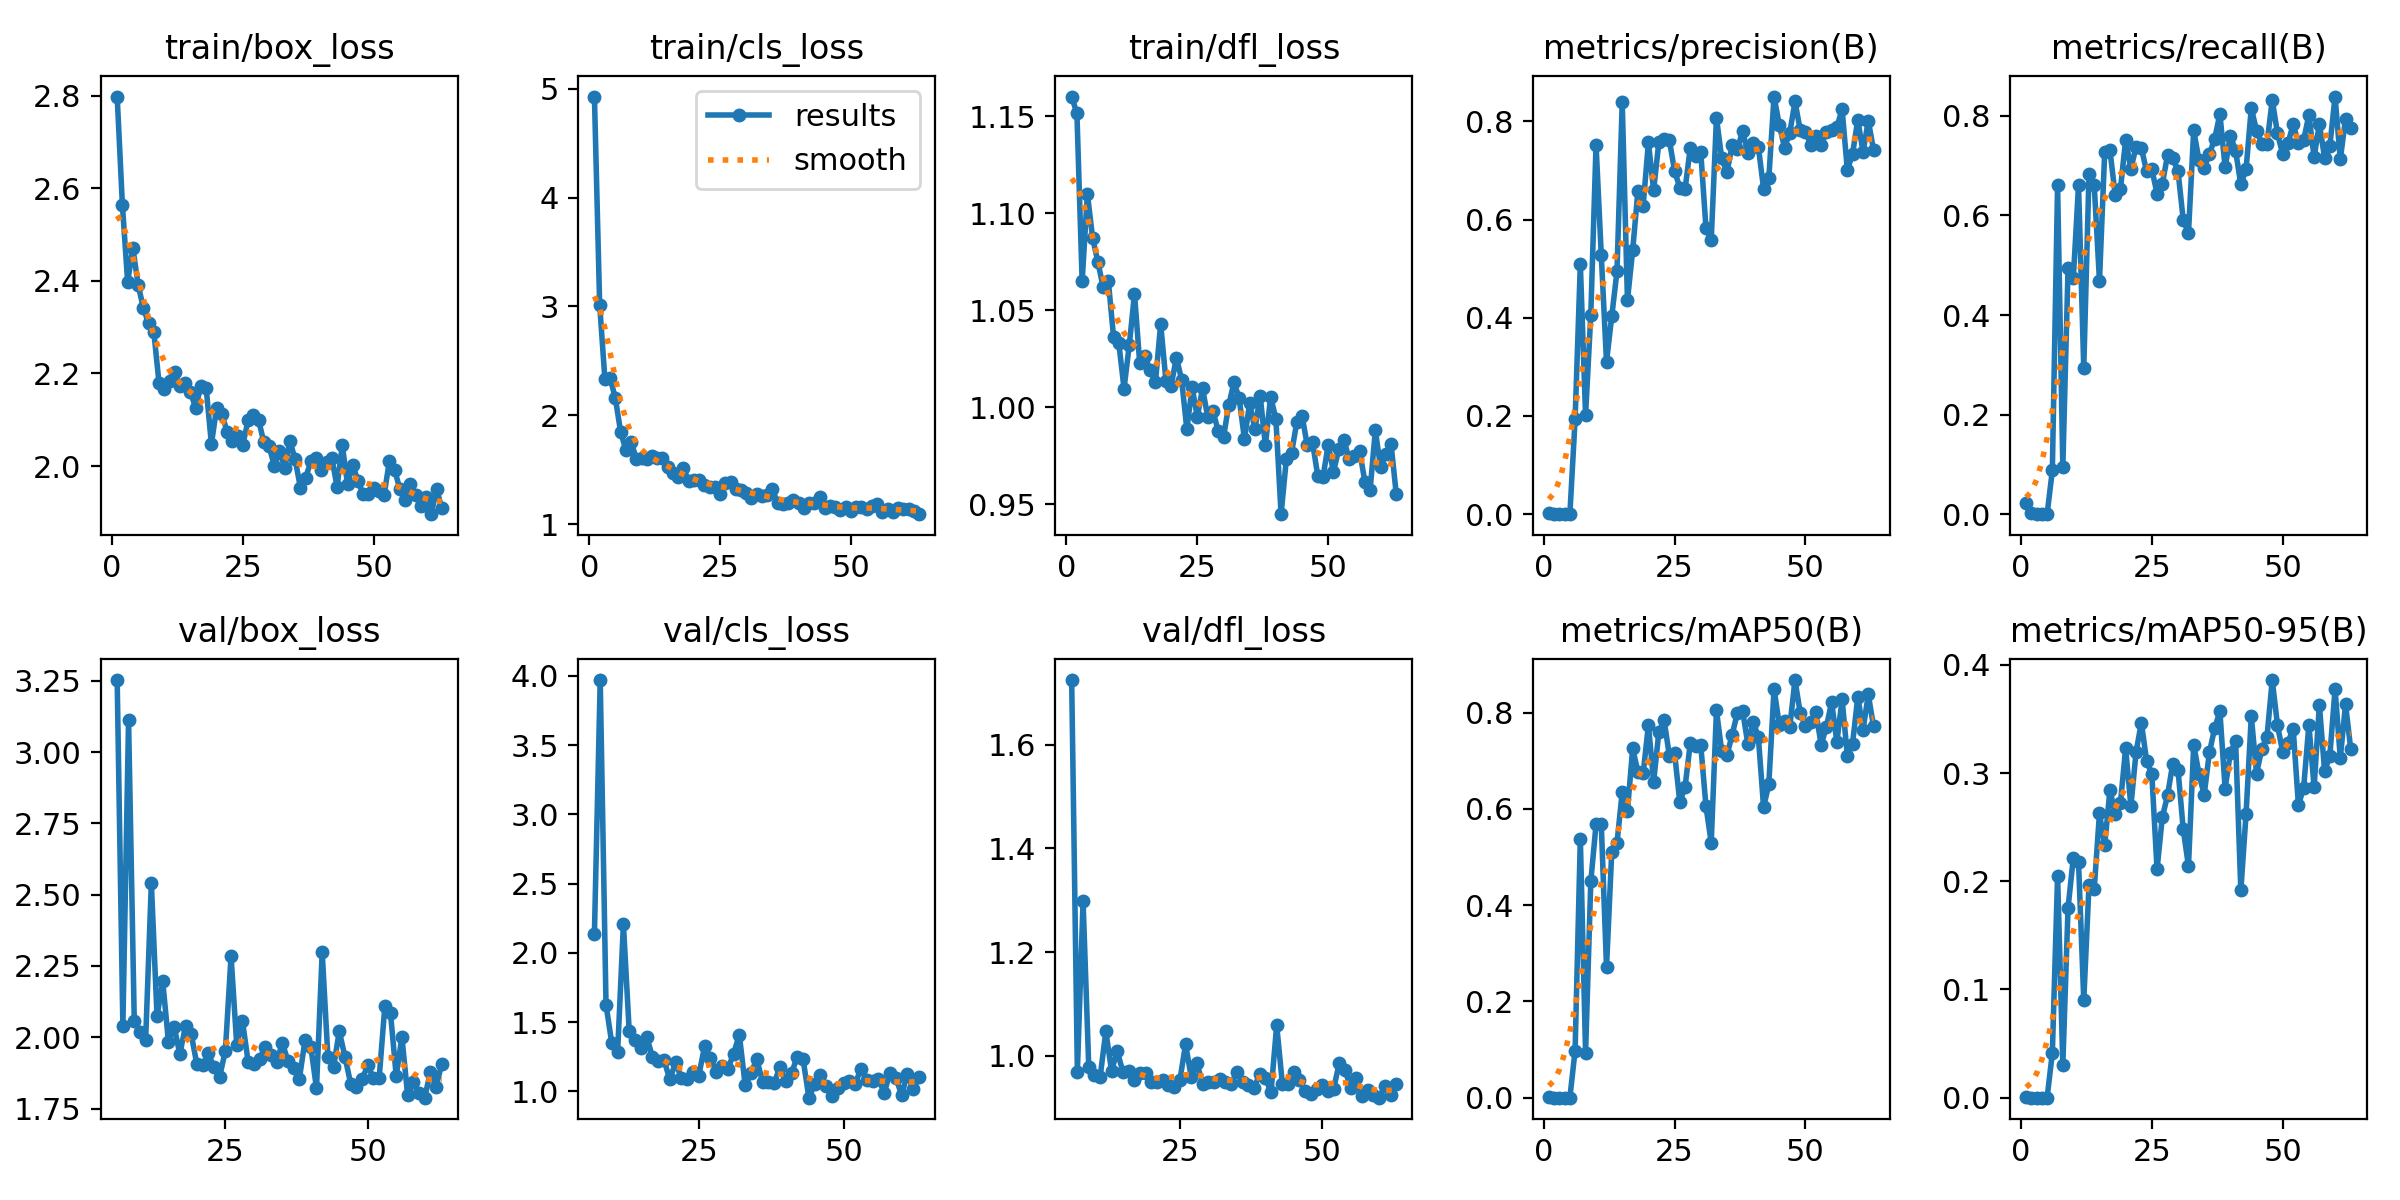


--- Confusion Matrix ---


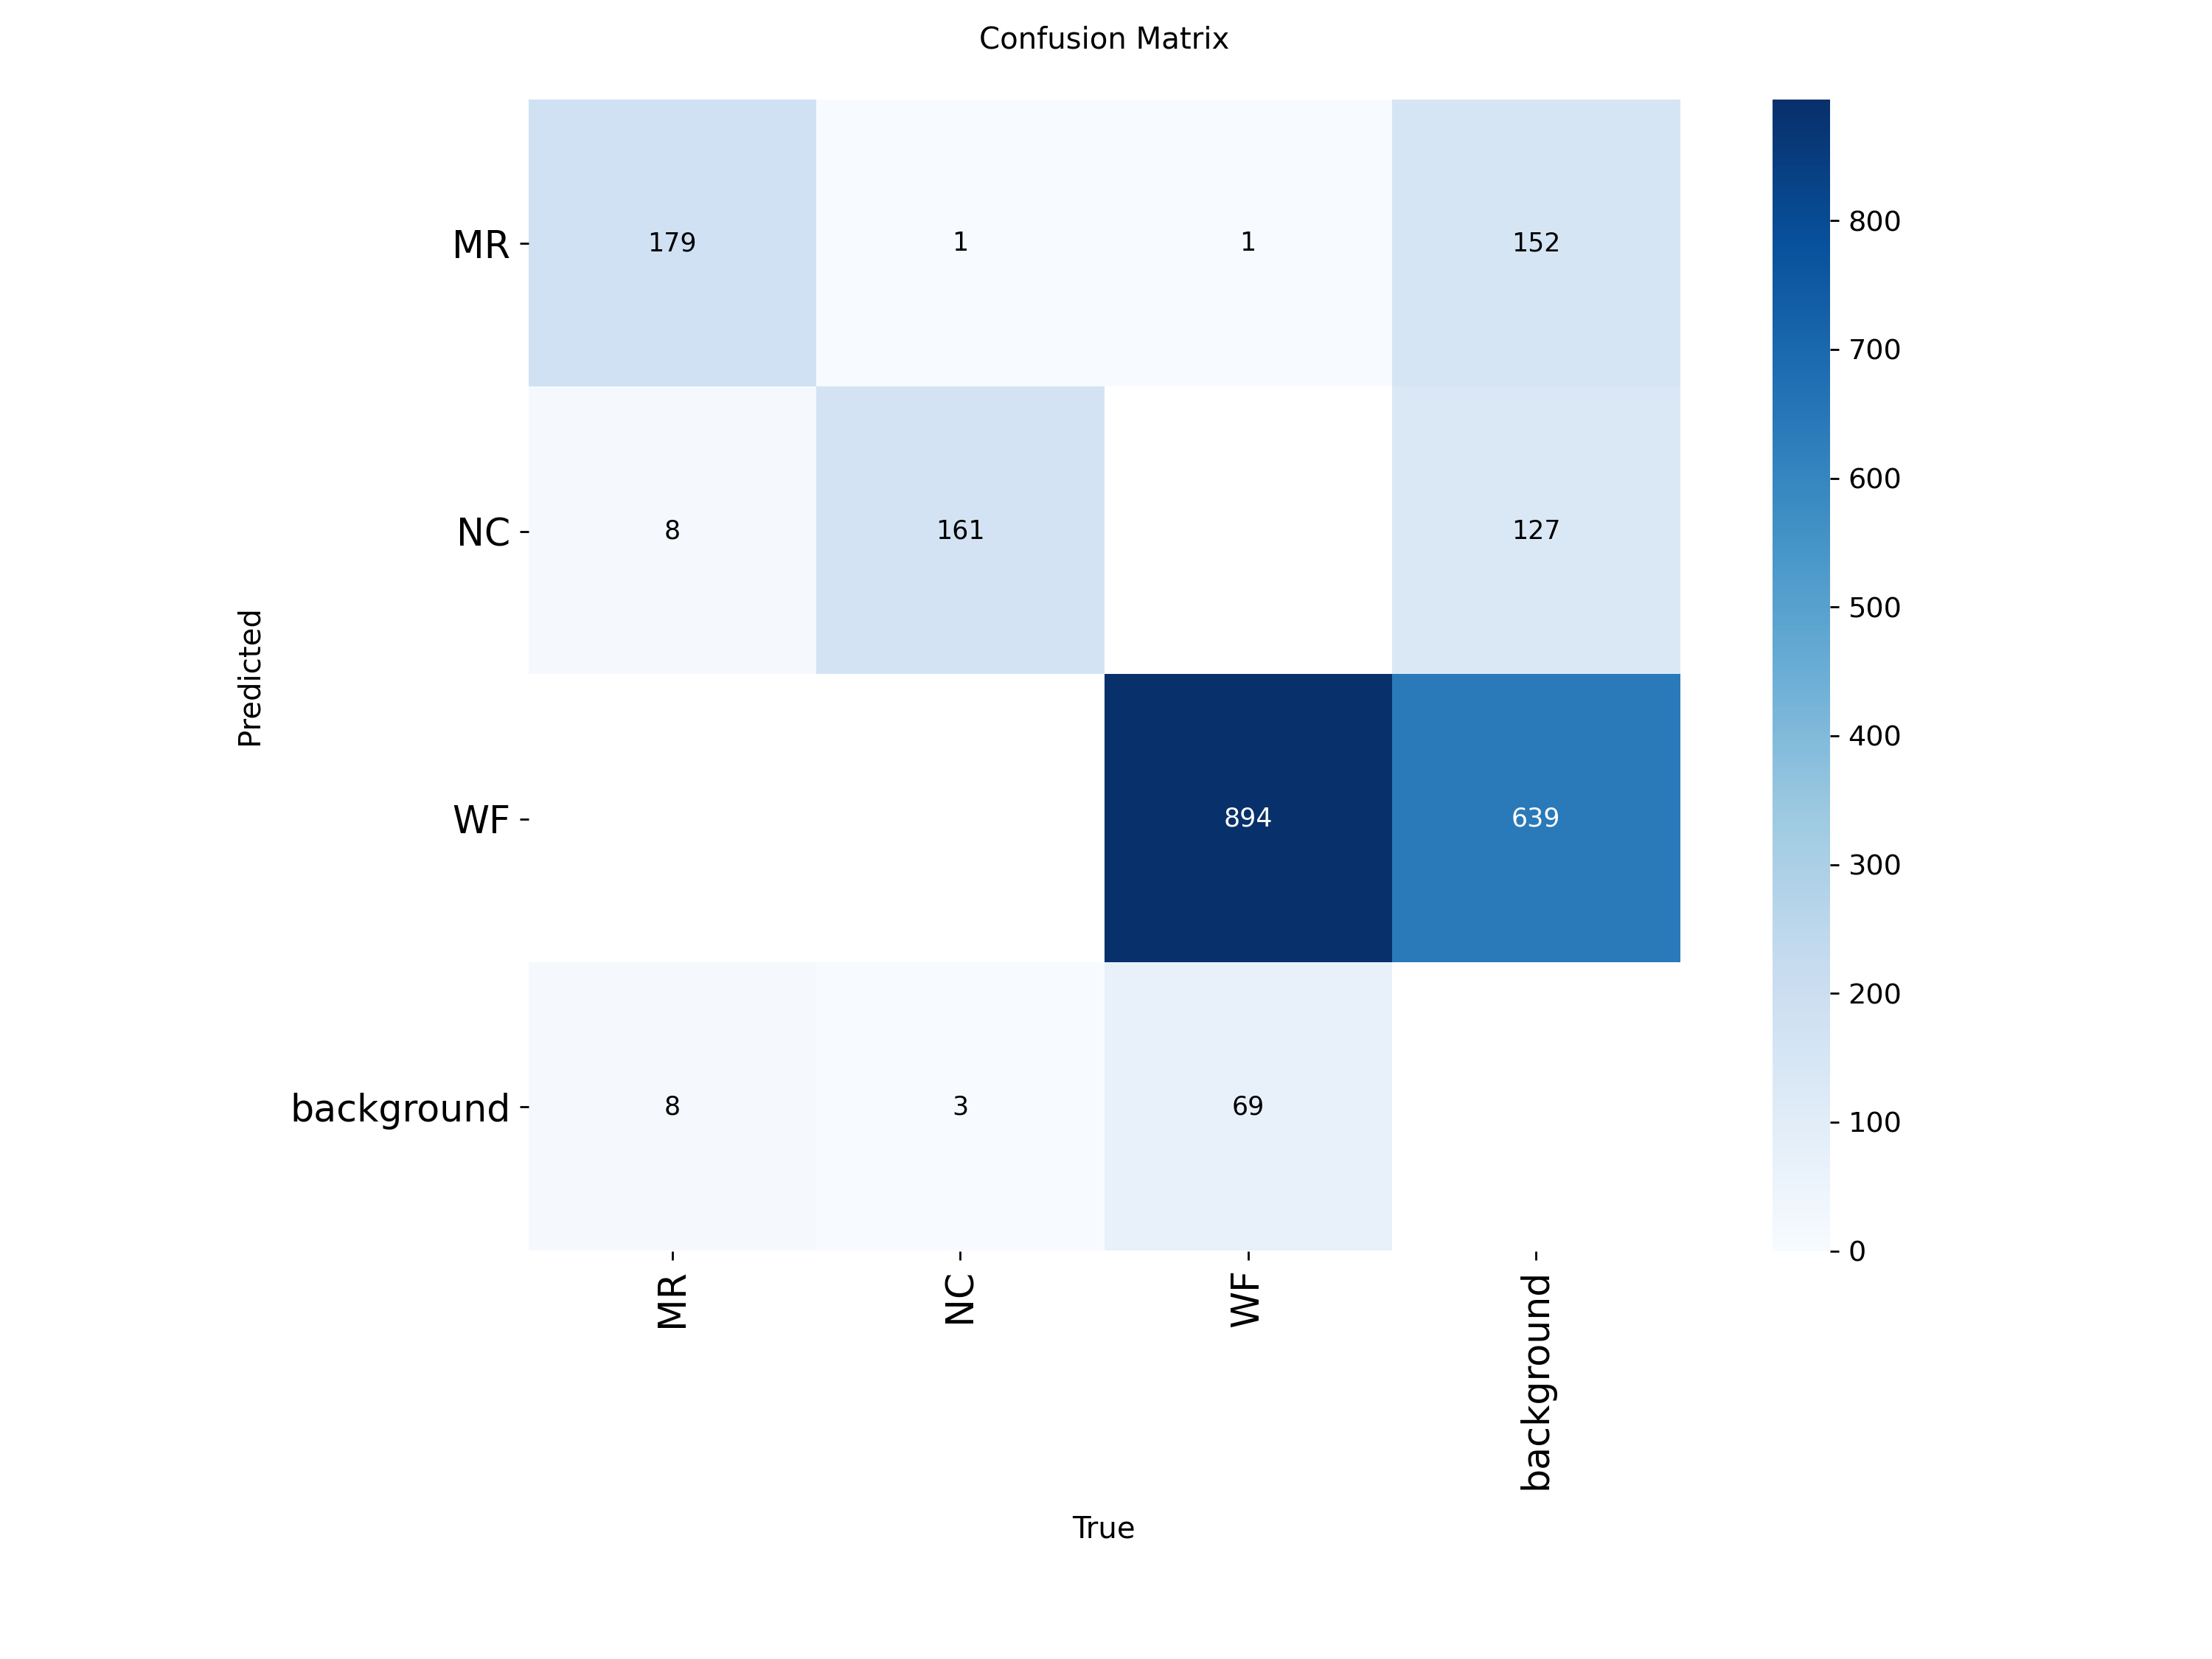

In [4]:
#Standard Metrics, Training Curves & Confusion Matrix

# Load the Best Trained Model
model = YOLO('/content/YOLOv8_Insect_Detection/definitive_working_run/weights/best.pt')


# Run Validation to Calculate Metrics
metrics = model.val(split='val') # use the validation set

print("\nPer-Class Metrics Table")

# Get the class names from the model's configuration
class_names = model.names

# Print the header for the table
print(f"{'Class':<15}{'Precision':>12}{'Recall':>12}{'mAP@.50':>12}{'mAP@.50-.95':>15}")
print("-" * 70)

# Get the lists of metrics directly from the metrics.box object
p_per_class = metrics.box.p      # Precision for each class
r_per_class = metrics.box.r      # Recall for each class
map50_per_class = metrics.box.ap50  # mAP@0.50 for each class
map_per_class = metrics.box.ap   # mAP@0.50-0.95 for each class

# Loop through each class and print its specific metrics
for i, name in class_names.items():
    # The index 'i' corresponds to the class ID
    print(f"{name:<15}{p_per_class[i]:>12.3f}{r_per_class[i]:>12.3f}{map50_per_class[i]:>12.3f}{map_per_class[i]:>15.3f}")

# Also print the overall 'all class' summary metrics, which are calculated by the .mean_results() method
mp, mr, map50, map95 = metrics.box.mean_results()
print("-" * 70)
print(f"{'all':<15}{mp:>12.3f}{mr:>12.3f}{map50:>12.3f}{map95:>15.3f}")


# Display Auto-Generated Plots
RESULTS_DIR = '/content/YOLOv8_Insect_Detection/definitive_working_run/'
print("\n\n--- Training & Validation Curves ---")
display(IPImage(filename=f'{RESULTS_DIR}/results.png', width=900))
print("\n--- Confusion Matrix ---")
display(IPImage(filename=f'{RESULTS_DIR}/confusion_matrix.png', width=600))

Running Advanced Visual Analysis on: 1044.jpg


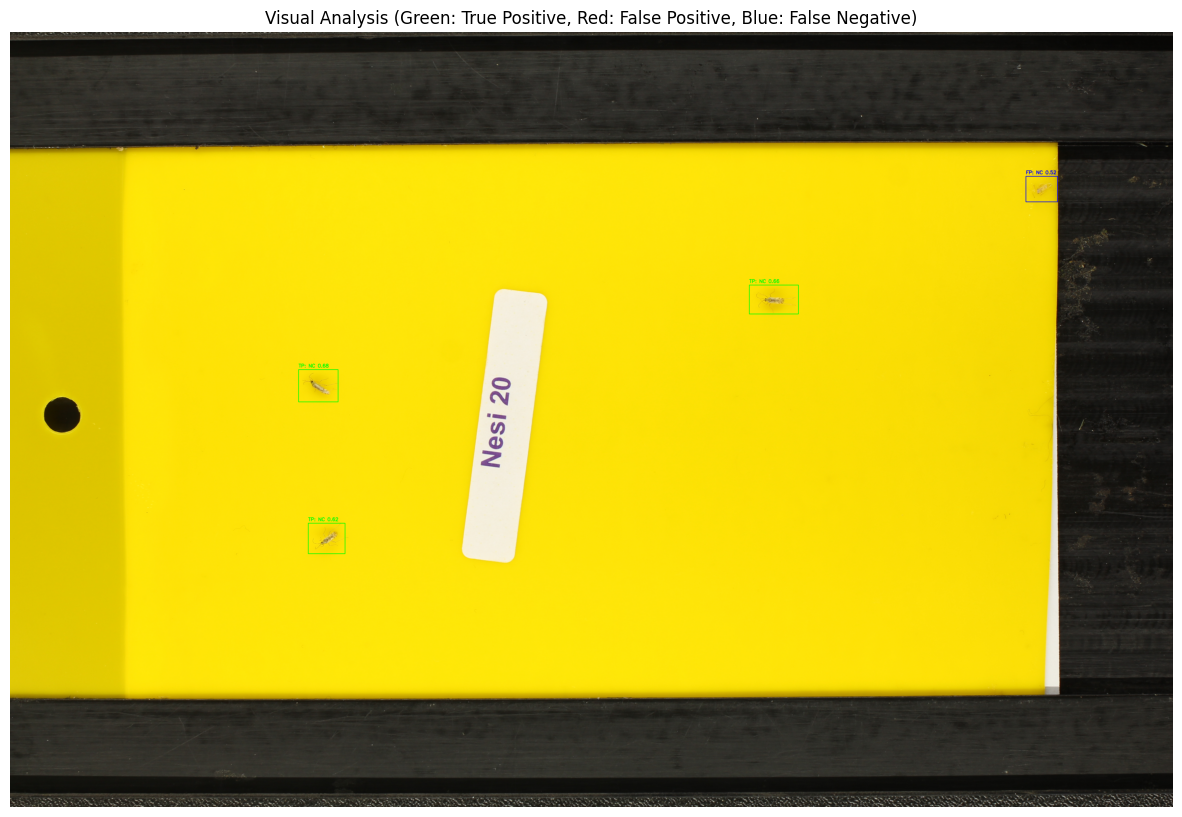

In [10]:
# Advanced Visual Analysis (True Positives & False Positives)

# This helper function calculates the Intersection over Union (IoU) between two boxes
# IoU is the core metric for deciding if a detection is correct
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_gt, y1_gt, x2_gt, y2_gt = box2
    xi1, yi1 = max(x1, x1_gt), max(y1, y1_gt)
    xi2, yi2 = min(x2, x2_gt), min(y2, y2_gt)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_gt - x1_gt) * (y2 - y1_gt)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area != 0 else 0

# Select a random test image and run the analysis
# A new 'test' directory for this purpose to use unseen data
TEST_DIR_IMG = os.path.join(YOLO_DATASET_DIR, 'images/test')
TEST_DIR_LBL = os.path.join(YOLO_DATASET_DIR, 'labels/test')

if not os.path.exists(TEST_DIR_IMG):
    # If the test set wasn't created in the YOLO structure, it must be created
    os.makedirs(TEST_DIR_IMG)
    os.makedirs(TEST_DIR_LBL)
    test_pairs = val_pairs # As a fallback, the validation pairs if test set is empty is used
    convert_and_copy(test_pairs, TEST_DIR_IMG, TEST_DIR_LBL)

random_image_path = random.choice(glob(os.path.join(TEST_DIR_IMG, '*.jpg')))
# Find the original XML path to get GT boxes for comparison
base_name_for_xml = os.path.splitext(os.path.basename(random_image_path))[0]
xml_path = os.path.join('/content/yellow-sticky-traps-dataset/annotations', base_name_for_xml + '.xml')

print(f"Running Advanced Visual Analysis on: {os.path.basename(random_image_path)}")

# Load image with OpenCV for drawing
image = cv2.imread(random_image_path)

# Get YOLOv8 predictions
results = model(random_image_path, verbose=False)
preds = results[0].boxes.data.cpu().numpy()

# Get ground truth boxes from the original XML file
tree = ET.parse(xml_path)
gt_boxes = []
class_names_map = {v: k for k, v in CLASS_MAPPING.items()}
for obj in tree.getroot().findall("object"):
    class_id = CLASS_MAPPING[obj.find("name").text]
    bndbox = obj.find("bndbox")
    gt_boxes.append([float(bndbox.find(t).text) for t in ['xmin', 'ymin', 'xmax', 'ymax']] + [class_id])

# Logic to determine TP, FP, FN
IOU_THRESHOLD = 0.5
gt_boxes_matched = [False] * len(gt_boxes)

# Check each prediction against all ground truth boxes
for pred in preds:
    x1, y1, x2, y2, conf, class_id = pred
    best_iou = 0
    match_idx = -1
    for i, gt_box in enumerate(gt_boxes):
        iou = calculate_iou(pred[:4], gt_box[:4])
        # A match requires high IoU and the same class ID
        if iou > best_iou and class_id == gt_box[4]:
            best_iou = iou
            match_idx = i

    # If a match is found, it's a True Positive (Green)
    if best_iou > IOU_THRESHOLD and not gt_boxes_matched[match_idx]:
        color = (0, 255, 0) # Green for TP
        label = f"TP: {class_names_map[int(class_id)]} {conf:.2f}"
        gt_boxes_matched[match_idx] = True
    # Otherwise, it's a False Positive (Red)
    else:
        color = (255, 0, 0) # Red for FP
        label = f"FP: {class_names_map[int(class_id)]} {conf:.2f}"
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
    cv2.putText(image, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

# Check for any ground truth boxes that were not matched (False Negatives - Blue)
for i, gt_box in enumerate(gt_boxes):
    if not gt_boxes_matched[i]:
        x1, y1, x2, y2, class_id = gt_box
        color = (0, 0, 255) # Blue for FN
        label = f"FN: {class_names_map[int(class_id)]}"
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

# Display the analyzed image
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Visual Analysis (Green: True Positive, Red: False Positive, Blue: False Negative)")
plt.show()

Processing validation images:   0%|          | 0/57 [00:00<?, ?it/s]


Plotting Histograms of Counting Errors


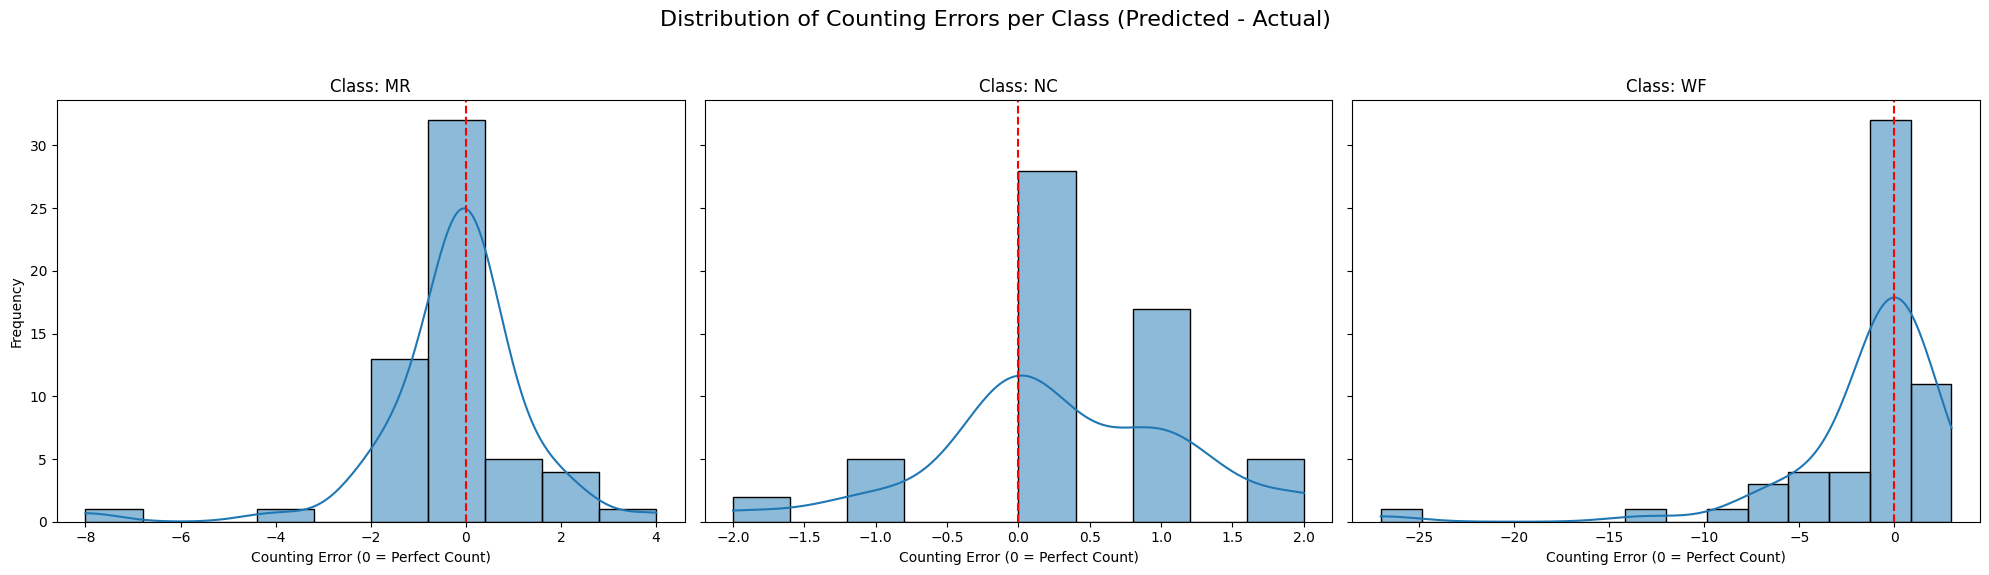

In [6]:
# Histogram of Counting Errors

# Using validation set for this analysis
image_files = glob(os.path.join(PATHS['val_images'], '*.jpg'))
counting_errors = {name: [] for name in CLASS_MAPPING.keys()}

# Loop through all images in the validation directory
for image_file in tqdm(image_files, desc="Processing validation images"):
    xml_file = os.path.join(SOURCE_ANNOTATIONS_DIR, os.path.basename(image_file).replace('.jpg', '.xml'))

    # Get Ground Truth Counts from the original XML
    gt_counts = {name: 0 for name in CLASS_MAPPING.keys()}
    if os.path.exists(xml_file):
        tree = ET.parse(xml_file)
        for obj in tree.getroot().findall("object"):
            class_name = obj.find("name").text
            if class_name in gt_counts:
                gt_counts[class_name] += 1

    # Get Predicted Counts from YOLOv8 model
    pred_counts = {name: 0 for name in CLASS_MAPPING.keys()}
    results = model(image_file, conf=0.4, verbose=False) # Confidence threshold
    for box in results[0].boxes:
        class_id = int(box.cls)
        class_name = class_names_map[class_id]
        if class_name in pred_counts:
            pred_counts[class_name] += 1

    # Calculate and store the error (Predicted - Actual) for each class
    for class_name in gt_counts:
        error = pred_counts[class_name] - gt_counts[class_name]
        counting_errors[class_name].append(error)

# Plotting the Histograms
print("\nPlotting Histograms of Counting Errors")
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
fig.suptitle('Distribution of Counting Errors per Class (Predicted - Actual)', fontsize=16)

for i, (class_name, errors) in enumerate(counting_errors.items()):
    ax = axes[i]
    sns.histplot(errors, ax=ax, bins=max(10, len(set(errors))), kde=True)
    ax.set_title(f'Class: {class_name}')
    ax.set_xlabel('Counting Error (0 = Perfect Count)')
    ax.axvline(0, color='r', linestyle='--') # Add a line at zero error for reference

axes[0].set_ylabel('Frequency')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Running Inference Speed Comparison
Testing on GPU...
GPU FPS: 3.30

Testing on CPU...
CPU FPS: 0.35


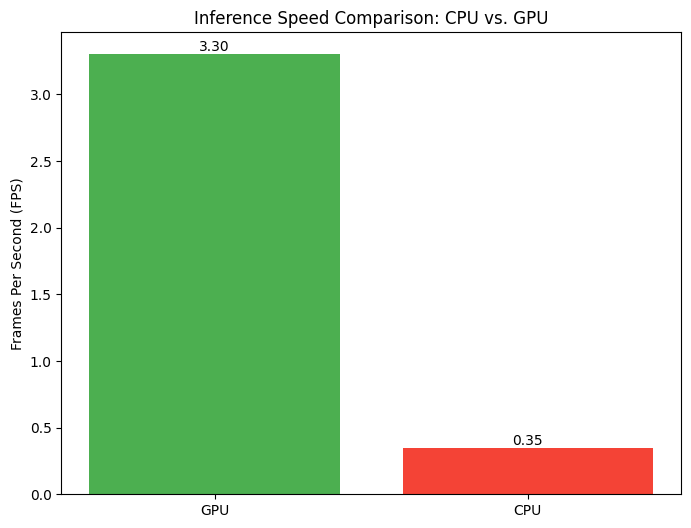

In [8]:
# Inference Speed Comparison (CPU vs. GPU)

# 1. Define the timing function
def time_inference(model, image, num_inferences=50):
    # Warm-up run (first inference is always slower)
    _ = model(image, verbose=False)

    # Measurement loop
    start_time = time.time()
    for _ in range(num_inferences):
        _ = model(image, verbose=False)
    end_time = time.time()

    # Calculate Frames Per Second (FPS)
    return num_inferences / (end_time - start_time)

# 2. Run tests on both devices
print("Running Inference Speed Comparison")
# Use a fixed test image for consistent results
test_image_path = random.choice(glob(os.path.join(PATHS['val_images'], '*.jpg')))
test_image = Image.open(test_image_path)
fps_results = {}

# GPU Test (if a GPU is available in the Colab runtime)
if torch.cuda.is_available():
    model_gpu = YOLO('/content/YOLOv8_Insect_Detection/definitive_working_run/weights/best.pt')
    print("Testing on GPU...")
    fps_gpu = time_inference(model_gpu, test_image)
    fps_results['GPU'] = fps_gpu
    print(f"GPU FPS: {fps_gpu:.2f}")
else:
    print("GPU not available")
    fps_results['GPU'] = 0

# CPU Test
model_cpu = YOLO('/content/YOLOv8_Insect_Detection/definitive_working_run/weights/best.pt')
model_cpu.to('cpu')
print("\nTesting on CPU...")
fps_cpu = time_inference(model_cpu, test_image)
fps_results['CPU'] = fps_cpu
print(f"CPU FPS: {fps_cpu:.2f}")

# 3. Plot Comparison Chart
plt.figure(figsize=(8, 6))
bars = plt.bar(fps_results.keys(), fps_results.values(), color=['#4CAF50', '#F44336'])
plt.title('Inference Speed Comparison: CPU vs. GPU')
plt.ylabel('Frames Per Second (FPS)')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center') # add text on top
plt.show()